In [1]:
import time
import argparse
import jax
import matplotlib.pyplot as plt
import optax
import matfree
import tree_math as tm
from flax import linen as nn
from jax import nn as jnn
from jax import numpy as jnp
from jax import random, jit
import pickle
from src.losses import mse_loss, accuracy_preds, nll
from src.helper import calculate_exact_ggn, tree_random_normal_like
from src.sampling.predictive_samplers import sample_predictive, sample_hessian_predictive
from jax import flatten_util
import matplotlib.pyplot as plt

import torch
from src.data.torch_datasets import MNIST, numpy_collate_fn

ImportError: cannot import name 'mse_loss' from 'src.losses' (/work3/hroy/geometric-laplace/src/losses.py)

## Train ConvNet

In [2]:
train_samples = 10#1000
train_samples = 300#1000
classes_train = [0,1,2,3,4,5,6,7,8,9]
n_classes = 10
batch_size = 256#20
test_batch_size = 256

data_train = MNIST(path_root= "/work3/hroy/data/",
            train=True, n_samples=train_samples if train_samples > 0 else None, cls=classes_train
        )
data_test = MNIST(path_root = "/work3/hroy/data/", train=False, cls=classes_train)

if train_samples > 0:
    N = train_samples * n_classes
else:
    N = len(data_train)
N_test = len(data_test)
if test_batch_size > 0:
    test_batch_size = test_batch_size
else:
    test_batch_size = len(data_test)

n_test_batches = int(N_test / test_batch_size)
n_batches = int(N / batch_size)

train_loader = torch.utils.data.DataLoader(
    data_train, batch_size=batch_size, shuffle=True, collate_fn=numpy_collate_fn, drop_last=True,
)

valid_loader = torch.utils.data.DataLoader(
    data_test, batch_size=test_batch_size, shuffle=True, collate_fn=numpy_collate_fn, drop_last=True,
)

In [3]:
class ConvNet(nn.Module):
    output_dim: int = 10

    @nn.compact
    def __call__(self, x):
        if len(x.shape) != 4:
            x = jnp.expand_dims(x, 0)
        x = jnp.transpose(x, (0, 2, 3, 1))
        x = nn.Conv(features=4, kernel_size=(3, 3), strides=(2, 2), padding=1)(x)
        x = nn.tanh(x)
        x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = nn.Conv(features=4, kernel_size=(3, 3), strides=(2, 2), padding=1)(x)
        x = nn.tanh(x)
        x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = x.reshape((x.shape[0], -1))
        return nn.Dense(features=self.output_dim)(x)

def compute_num_params(pytree):
    return sum(x.size if hasattr(x, "size") else 0 for x in jax.tree_util.tree_leaves(pytree))


model = ConvNet()
batch = next(iter(train_loader))
x_init, y_init = batch["image"], batch["label"]
output_dim = y_init.shape[-1]
key, split_key = random.split(jax.random.PRNGKey(0))
params = model.init(key, x_init)
alpha = 1.
optim = optax.chain(
        optax.clip(1.),
        getattr(optax, "adam")(1e-2),
    )
opt_state = optim.init(params)
n_params = compute_num_params(params)
n_epochs = 100

In [4]:
def cross_entropy_loss(preds, y, rho=1.0):
    """
    preds: (n_samples, n_classes) (logits)
    y: (n_samples, n_classes) (one-hot labels)
    """
    preds = preds * rho
    preds = jax.nn.log_softmax(preds, axis=-1)
    return -jnp.sum(jnp.sum(preds * y, axis=-1))

def accuracy(params, model, batch_x, batch_y):
    preds = model.apply(params, batch_x)
    return jnp.sum(preds.argmax(axis=-1) == batch_y.argmax(axis=-1))


def map_loss(
    params,
    model,
    x_batch,
    y_batch,
    alpha,
    n_params: int,
    N_datapoints_max: int,
):
    # define dict for logging purposes
    B = x_batch.shape[0]
    O = y_batch.shape[-1]
    D = n_params
    N = N_datapoints_max

    # hessian_scaler = 1

    vparams = tm.Vector(params)

    rho = 1.
    nll = lambda x, y, rho: 1/B * cross_entropy_loss(x, y, rho)

    y_pred = model.apply(params, x_batch)

    loglike_loss = nll(y_pred, y_batch, rho) #* hessian_scaler

    log_prior_term = -D / 2 * jnp.log(2 * jnp.pi) - (1 / 2) * alpha * (vparams @ vparams) + D / 2 * jnp.log(alpha)
    # log_det_term = 0
    loss = loglike_loss - 0. * log_prior_term

    return loss

def make_step(params, alpha, opt_state, x, y):
    grad_fn = jax.value_and_grad(map_loss, argnums=0, has_aux=False)
    loss, grads = grad_fn(params, model, x, y, alpha, n_params, N)
    param_updates, opt_state = optim.update(grads, opt_state)
    params = optax.apply_updates(params, param_updates)
    return loss, params, opt_state

jit_make_step = jit(make_step)



In [5]:
for epoch in range(1, n_epochs + 1):
    epoch_loss = 0
    epoch_accuracy = 0
    start_time = time.time()
    for _, batch in zip(range(n_batches), train_loader):
        X = batch["image"]
        y = batch["label"]
        B = X.shape[0]
        train_key, split_key = random.split(split_key)

        loss, params, opt_state = jit_make_step(params, alpha, opt_state, X, y)
        loss = loss
        epoch_loss += loss.item()

        epoch_accuracy += accuracy(params, model, X, y).item()

    epoch_accuracy /= (n_batches * B)
    epoch_time = time.time() - start_time
    print(
        f"epoch={epoch}, loss={epoch_loss:.3f}, , accuracy={epoch_accuracy:.2f}, alpha={alpha:.2f}, time={epoch_time:.3f}s"
    )


epoch=1, loss=25.162, , accuracy=0.17, alpha=1.00, time=1.506s
epoch=2, loss=23.608, , accuracy=0.25, alpha=1.00, time=0.348s
epoch=3, loss=21.387, , accuracy=0.45, alpha=1.00, time=0.351s
epoch=4, loss=18.559, , accuracy=0.53, alpha=1.00, time=0.345s
epoch=5, loss=15.972, , accuracy=0.57, alpha=1.00, time=0.346s
epoch=6, loss=13.639, , accuracy=0.64, alpha=1.00, time=0.349s
epoch=7, loss=12.058, , accuracy=0.68, alpha=1.00, time=0.346s
epoch=8, loss=10.933, , accuracy=0.71, alpha=1.00, time=0.351s
epoch=9, loss=10.108, , accuracy=0.73, alpha=1.00, time=0.338s
epoch=10, loss=9.513, , accuracy=0.74, alpha=1.00, time=0.339s
epoch=11, loss=8.994, , accuracy=0.76, alpha=1.00, time=0.341s
epoch=12, loss=8.700, , accuracy=0.76, alpha=1.00, time=0.350s
epoch=13, loss=8.272, , accuracy=0.77, alpha=1.00, time=0.346s
epoch=14, loss=8.000, , accuracy=0.79, alpha=1.00, time=0.338s
epoch=15, loss=7.700, , accuracy=0.78, alpha=1.00, time=0.341s
epoch=16, loss=7.675, , accuracy=0.79, alpha=1.00, time

## Sampling

In [6]:
sampling_train_loader = torch.utils.data.DataLoader(
    data_train, batch_size=N, shuffle=True, collate_fn=numpy_collate_fn, drop_last=True,
)
data = next(iter(sampling_train_loader))
x_train = jnp.array(data["image"])
y_train = jnp.array(data["label"])
sampling_val_loader = torch.utils.data.DataLoader(
    data_test, batch_size=N_test, shuffle=True, collate_fn=numpy_collate_fn, drop_last=True,
)
data = next(iter(sampling_val_loader))
x_val = jnp.array(data["image"])
y_val = jnp.array(data["label"])

sample_key = jax.random.PRNGKey(0)
n_posterior_samples = 200
num_iterations = 1
n_sample_batch_size = 1
n_sample_batches = N // n_sample_batch_size

In [7]:
from src.sampling.exact_ggn import exact_ggn_laplace
from src.sampling.laplace_ode import ode_ggn
from src.sampling.lanczos_diffusion import lanczos_diffusion


In [8]:
_model_fn = lambda params, x: model.apply(params, x[None, ...])[0]
ggn = calculate_exact_ggn(cross_entropy_loss, _model_fn, params, x_train[:120], y_train[:120], n_params)


In [9]:
jnp.linalg.matrix_rank(ggn)

Array(226, dtype=int32)

In [10]:
x_train.shape

(3000, 1, 28, 28)

In [11]:
sample_key = jax.random.PRNGKey(0)
model_fn = lambda params, x: model.apply(params, x[None, ...])[0]
rank = 10
alpha = 1.0
n_posterior_samples = 200
var = 0.1

lr_posterior_samples, posterior_samples, isotropic_posterior_samples = exact_ggn_laplace(cross_entropy_loss, 
                                                                                         model_fn,
                                                                                         params,
                                                                                         x_train[:30],
                                                                                         y_train[:30],
                                                                                         n_params,
                                                                                         rank,
                                                                                         alpha,
                                                                                         n_posterior_samples,
                                                                                         sample_key,
                                                                                         var,
                                                                                         "all"
                                                                                         )

In [15]:
from functools import partial

# @partial(jax.jit, static_argnames=['n_data_pts'])
def rank_expt(n_data_pts, train_stats=True, mean_acc=True):
    sample_key = jax.random.PRNGKey(0)
    model_fn = lambda params, x: model.apply(params, x[None, ...])[0]
    rank = 100
    alpha = 1.0
    n_posterior_samples = 200
    var = 0.1

    lr_posterior_samples, posterior_samples, isotropic_posterior_samples = exact_ggn_laplace(cross_entropy_loss, 
                                                                   model_fn,
                                                                   params,
                                                                   x_train[:n_data_pts],
                                                                   y_train[:n_data_pts],
                                                                   n_params,
                                                                   rank,
                                                                   alpha,
                                                                   n_posterior_samples,
                                                                   sample_key,
                                                                   var,
                                                                   "all"
                                                                   )
    
    if train_stats:
        n_data_pts = 3000
        lr_predictive = sample_predictive(lr_posterior_samples, params, model, x_train[:n_data_pts], False, "Pytree")
        predictive = sample_predictive(posterior_samples, params, model, x_train[:n_data_pts], False, "Pytree")
        linearised_predictive = sample_predictive(posterior_samples, params, model, x_train[:n_data_pts], True, "Pytree")
        isotropic_predictive = sample_predictive(isotropic_posterior_samples, params, model, x_train[:n_data_pts], False, "Pytree")
        map_acc = accuracy(params, model, x_train[:n_data_pts], y_train[:n_data_pts])/n_data_pts
        if mean_acc:
            lr_acc = jnp.mean(jax.vmap(accuracy_preds, in_axes=(0,None))(lr_predictive, y_train[:n_data_pts])/n_data_pts)
            linearised_acc = jnp.mean(jax.vmap(accuracy_preds, in_axes=(0,None))(linearised_predictive, y_train[:n_data_pts])/n_data_pts)
            full_acc = jnp.mean(jax.vmap(accuracy_preds, in_axes=(0,None))(predictive, y_train[:n_data_pts])/n_data_pts)
            isotropic_acc = jnp.mean(jax.vmap(accuracy_preds, in_axes=(0,None))(isotropic_predictive, y_train[:n_data_pts])/n_data_pts)
        else:
            lr_acc = accuracy_preds(lr_predictive.mean(axis=0), y_train[:n_data_pts])/ n_data_pts 
            linearised_acc = accuracy_preds(linearised_predictive.mean(axis=0), y_train[:n_data_pts])/ n_data_pts 
            full_acc = accuracy_preds(predictive.mean(axis=0), y_train[:n_data_pts])/ n_data_pts 
            isotropic_acc = accuracy_preds(isotropic_predictive.mean(axis=0), y_train[:n_data_pts])/ n_data_pts
        return map_acc, lr_acc, linearised_acc, full_acc, isotropic_acc
        
    else:
        N_val = 1000
        lr_predictive = sample_predictive(lr_posterior_samples, params, model, x_val[:N_val], False, "Pytree")
        predictive = sample_predictive(posterior_samples, params, model, x_val[:N_val], False, "Pytree")
        linearised_predictive = sample_predictive(posterior_samples, params, model, x_val[:N_val], True, "Pytree")
        isotropic_predictive = sample_predictive(isotropic_posterior_samples, params, model, x_val[:N_val], False, "Pytree")
        map_acc = accuracy(params, model, x_train[:n_data_pts], y_train[:n_data_pts])/n_data_pts
        if mean_acc:
            lr_acc = jnp.mean(jax.vmap(accuracy_preds, in_axes=(0,None))(lr_predictive, y_train[:N_val])/N_val)
            linearised_acc = jnp.mean(jax.vmap(accuracy_preds, in_axes=(0,None))(linearised_predictive, y_train[:N_val])/N_val)
            full_acc = jnp.mean(jax.vmap(accuracy_preds, in_axes=(0,None))(predictive, y_train[:N_val])/N_val)
            isotropic_acc = jnp.mean(jax.vmap(accuracy_preds, in_axes=(0,None))(isotropic_predictive, y_train[:N_val])/N_val)
        else:
            lr_acc = accuracy_preds(lr_predictive.mean(axis=0), y_train[:N_val])/ N_val 
            linearised_acc = accuracy_preds(linearised_predictive.mean(axis=0), y_train[:N_val])/ N_val 
            full_acc = accuracy_preds(predictive.mean(axis=0), y_train[:N_val])/ N_val 
            isotropic_acc = accuracy_preds(isotropic_predictive.mean(axis=0), y_train[:N_val])/ N_val
        return map_acc, lr_acc, linearised_acc, full_acc, isotropic_acc
    

    
        

In [16]:
n_data_pt_list = jnp.array([ 50, 75, 100, 120, 150, 200, 250, 300, 500, 1000])
map_acc_list, lr_acc_list, linearised_acc_list, full_acc_list, isotropic_acc_list = [], [], [], [], []
for n_data_pt in n_data_pt_list:
    map_acc, lr_acc, linearised_acc, full_acc, isotropic_acc = rank_expt(n_data_pt)
    map_acc_list.append(map_acc)
    lr_acc_list.append(lr_acc)
    linearised_acc_list.append(linearised_acc)
    full_acc_list.append(full_acc)
    isotropic_acc_list.append(isotropic_acc)

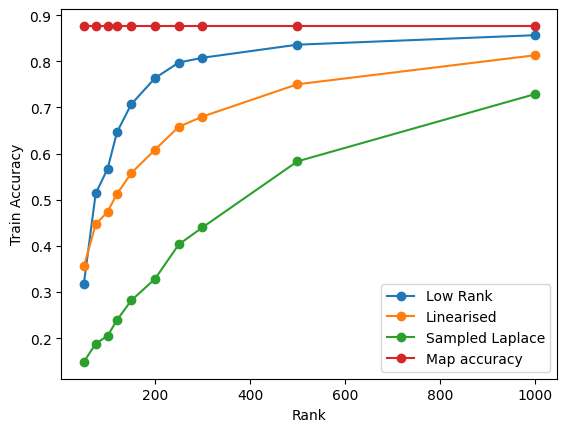

In [17]:
map_acc_list, lr_acc_list, linearised_acc_list, full_acc_list, isotropic_acc_list = jnp.array(map_acc_list), jnp.array(lr_acc_list), jnp.array(linearised_acc_list), jnp.array(full_acc_list), jnp.array(isotropic_acc_list)
plt.plot(n_data_pt_list, lr_acc_list, label="Low Rank", marker="o")
plt.plot(n_data_pt_list, linearised_acc_list, label="Linearised", marker="o")
plt.plot(n_data_pt_list, full_acc_list, label="Sampled Laplace", marker="o")
plt.plot(n_data_pt_list, map_acc_list, label="Map accuracy", marker="o")
# plt.plot(n_data_pt_list, isotropic_acc_list, label="Isotropic accuracy", marker="o")
plt.xlabel("Rank")
# plt.xticks(n_data_pt_list)
plt.ylabel("Train Accuracy")
plt.legend()

In [50]:
N_val = 1000
lr_predictive = sample_predictive(lr_posterior_samples, params, model, x_train[:30], False, "Pytree")
predictive = sample_predictive(posterior_samples, params, model, x_train[:30], False, "Pytree")
isotropic_predictive = sample_predictive(isotropic_posterior_samples, params, model, x_train[:30], False, "Pytree")
preds = model.apply(params, x_train[:30])
print("MAP acc:", accuracy(params, model, x_train[:30], y_train[:30])/x_train[:30].shape[0])
print("lr acc:", jnp.mean(jax.vmap(accuracy_preds, in_axes=(0,None))(lr_predictive, y_train[:30])/x_train[:30].shape[0]))
print("full acc:", jnp.mean(jax.vmap(accuracy_preds, in_axes=(0,None))(predictive, y_train[:30])/x_train[:30].shape[0]))
print("isotropic acc:", jnp.mean(jax.vmap(accuracy_preds, in_axes=(0,None))(isotropic_predictive, y_train[:30])/x_train[:30].shape[0]))



MAP acc: 0.8333333
lr acc: 0.79800004
full acc: 0.14366667
isotropic acc: 0.7725


In [59]:
accuracy_preds(isotropic_predictive.mean(axis=0), y_train[:30])/30

Array(0.8333333, dtype=float32)

In [48]:
N_val = 1000
lr_predictive = sample_predictive(lr_posterior_samples, params, model, x_val[:N_val], False, "Pytree")
predictive = sample_predictive(posterior_samples, params, model, x_val[:N_val], False, "Pytree")
isotropic_predictive = sample_predictive(isotropic_posterior_samples, params, model, x_val[:N_val], False, "Pytree")
preds = model.apply(params, x_val[:N_val])


In [49]:
print("MAP acc:", accuracy(params, model, x_val[:N_val], y_val[:N_val])/x_val[:N_val].shape[0])
print("lr acc:", jnp.mean(jax.vmap(accuracy_preds, in_axes=(0,None))(lr_predictive, y_val[:N_val])/x_val[:N_val].shape[0]))
print("full acc:", jnp.mean(jax.vmap(accuracy_preds, in_axes=(0,None))(predictive, y_val[:N_val])/x_val[:N_val].shape[0]))
print("isotropic acc:", jnp.mean(jax.vmap(accuracy_preds, in_axes=(0,None))(isotropic_predictive, y_val[:N_val])/x_val[:N_val].shape[0]))


MAP acc: 0.853
lr acc: 0.81091
full acc: 0.15518999
isotropic acc: 0.78494996


In [46]:
print("MAP nll:", nll(preds, y_val[:N_val]))
print("lr nll:", nll(lr_predictive, y_val[:N_val]))
print("full nll:", nll(predictive, y_val[:N_val]))
print("isotropic nll:", nll(isotropic_predictive, y_val[:N_val]))


MAP nll: 473.9449
lr nll: 670.9823
full nll: 7545.1475
isotropic nll: 685.7618


In [14]:
lr_predictive = sample_predictive(lr_posterior_samples, params, model, x_val[:N_val], True, "Pytree")
predictive = sample_predictive(posterior_samples, params, model, x_val[:N_val], True, "Pytree")
isotropic_predictive = sample_predictive(isotropic_posterior_samples, params, model, x_val[:N_val], True, "Pytree")


In [15]:
isotropic_predictive.shape

(200, 1000, 10)

In [16]:
print("MAP acc:", accuracy(params, model, x_val[:N_val], y_val[:N_val])/x_val[:N_val].shape[0])
print("lr acc:", jnp.mean(jax.vmap(accuracy_preds, in_axes=(0,None))(lr_predictive, y_val[:N_val])/x_val[:N_val].shape[0]))
print("full acc:", jnp.mean(jax.vmap(accuracy_preds, in_axes=(0,None))(predictive, y_val[:N_val])/x_val[:N_val].shape[0]))
print("isotropic acc:", jnp.mean(jax.vmap(accuracy_preds, in_axes=(0,None))(isotropic_predictive, y_val[:N_val])/x_val[:N_val].shape[0]))


MAP acc: 0.843
lr acc: 0.842125
full acc: 0.812935
isotropic acc: 0.77391493


In [17]:
print("MAP nll:", nll(preds, y_val[:N_val]))
print("lr nll:", nll(lr_predictive, y_val[:N_val]))
print("full nll:", nll(predictive, y_val[:N_val]))
print("isotropic nll:", nll(isotropic_predictive, y_val[:N_val]))


MAP nll: 537.5515
lr nll: 540.08307
full nll: 624.62225
isotropic nll: 747.6211


## OOD

In [18]:
from src.data.datasets import (
    get_rotated_mnist_loaders,
    load_corrupted_cifar10,
    get_mnist_ood_loaders,
    get_cifar10_ood_loaders,
    get_cifar10_train_set,
)

In [19]:
eval_args = {}
eval_args["linearised_laplace"] = False
eval_args["posterior_sample_type"] = "Pytree"
eval_args["likelihood"] = "classification"


In [52]:
from src.ood_functions.evaluate import evaluate
from src.ood_functions.metrics import compute_metrics
ids = [0, 15, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 345, 360]
n_datapoint=500
ood_batch_size = 50
metrics = []
for i, id in enumerate(ids):    
    _, test_loader = get_rotated_mnist_loaders(id, data_path="data", download=True, batch_size=ood_batch_size, n_datapoint=n_datapoint)
    some_metrics, all_y_prob, all_y_true, all_y_var = evaluate(test_loader, lr_posterior_samples, params, model, eval_args)
    if i == 0:
        all_y_prob_in = all_y_prob
    more_metrics = compute_metrics(
            i, id, all_y_prob, test_loader, all_y_prob_in, all_y_var, benchmark="R-MNIST"
        )
    metrics.append({**some_metrics, **more_metrics})
    print(", ".join([f"{k}: {v:.4f}" for k, v in metrics[-1].items()]))
    


R-MNIST with distribution shift intensity 0
conf: 0.8293, nll: 297.9814, acc: 0.8140, brier: 0.2763, ece: 0.1219, mce: 0.7098
R-MNIST with distribution shift intensity 1
conf: 0.7904, nll: 402.6505, acc: 0.7320, brier: 0.3799, ece: 0.1402, mce: 0.6985
R-MNIST with distribution shift intensity 2
conf: 0.7345, nll: 886.8191, acc: 0.4980, brier: 0.7143, ece: 0.2762, mce: 0.7698
R-MNIST with distribution shift intensity 3
conf: 0.6773, nll: 1994.0592, acc: 0.1980, brier: 1.1895, ece: 0.4839, mce: 0.9056
R-MNIST with distribution shift intensity 4
conf: 0.6894, nll: 2437.9873, acc: 0.1620, brier: 1.2652, ece: 0.5363, mce: 0.9752
R-MNIST with distribution shift intensity 5
conf: 0.6485, nll: 2278.5176, acc: 0.1620, brier: 1.2186, ece: 0.4859, mce: 0.8357
R-MNIST with distribution shift intensity 6
conf: 0.6566, nll: 2078.4587, acc: 0.1760, brier: 1.1976, ece: 0.4802, mce: 0.9545
R-MNIST with distribution shift intensity 7
conf: 0.7467, nll: 2250.4639, acc: 0.2840, brier: 1.1244, ece: 0.4850,

In [53]:
from src.ood_functions.evaluate import evaluate
# from src.ood_functions.metrics import compute_metrics
ids = [0, 15, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 345, 360]
n_datapoint=500
ood_batch_size = 50
metrics = []
for i, id in enumerate(ids):    
    _, test_loader = get_rotated_mnist_loaders(id, data_path="data", download=True, batch_size=ood_batch_size, n_datapoint=n_datapoint)
    some_metrics, all_y_prob, all_y_true, all_y_var = evaluate(test_loader, posterior_samples, params, model, eval_args)
    if i == 0:
        all_y_prob_in = all_y_prob
    more_metrics = compute_metrics(
            i, id, all_y_prob, test_loader, all_y_prob_in, all_y_var, benchmark="R-MNIST"
        )
    metrics.append({**some_metrics, **more_metrics})
    print(", ".join([f"{k}: {v:.4f}" for k, v in metrics[-1].items()]))
    


R-MNIST with distribution shift intensity 0
conf: 0.8126, nll: 286.0074, acc: 0.8160, brier: 0.2681, ece: 0.1080, mce: 0.7015
R-MNIST with distribution shift intensity 1
conf: 0.7734, nll: 385.7637, acc: 0.7460, brier: 0.3662, ece: 0.1366, mce: 0.8287
R-MNIST with distribution shift intensity 2
conf: 0.7114, nll: 842.7404, acc: 0.5000, brier: 0.7018, ece: 0.2386, mce: 0.6550
R-MNIST with distribution shift intensity 3
conf: 0.6617, nll: 1906.2975, acc: 0.1900, brier: 1.1863, ece: 0.4762, mce: 0.8752
R-MNIST with distribution shift intensity 4
conf: 0.6748, nll: 2343.8108, acc: 0.1620, brier: 1.2489, ece: 0.5192, mce: 0.8548
R-MNIST with distribution shift intensity 5
conf: 0.6342, nll: 2185.4668, acc: 0.1640, brier: 1.1982, ece: 0.4690, mce: 0.9887
R-MNIST with distribution shift intensity 6
conf: 0.6332, nll: 1971.8813, acc: 0.1800, brier: 1.1739, ece: 0.4579, mce: 0.9133
R-MNIST with distribution shift intensity 7
conf: 0.7272, nll: 2125.1313, acc: 0.2820, brier: 1.1018, ece: 0.4448,

### Lanczos diffusion

In [59]:
n_steps = 2
n_samples = 50
alpha = 10.0
rank = 10
nonker_posterior_samples = lanczos_diffusion(cross_entropy_loss, model.apply, params,n_steps,n_samples,alpha,sample_key,n_params,rank,x_train,y_train,1.0,"non-kernel-eigvals")

In [63]:
nonker_predictive = sample_predictive(nonker_posterior_samples, params, model, x_val[:N_val], False, "Pytree")
preds = model.apply(params, x_val[:N_val])


In [64]:
print("MAP acc:", accuracy(params, model, x_val[:N_val], y_val[:N_val])/x_val[:N_val].shape[0])
print("nonker acc:", jnp.mean(jax.vmap(accuracy_preds, in_axes=(0,None))(nonker_predictive, y_val[:N_val])/x_val[:N_val].shape[0]))
print("MAP nll:", nll(preds, y_val[:N_val]))
print("nonker nll:", nll(nonker_predictive, y_val[:N_val]))



MAP acc: 0.832
nonker acc: 0.83283997
MAP nll: 520.5774
nonker nll: 522.54913


### ODE